In this blog post, I will discuss how can you train a simple classifier for a XOR function using theano. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.externals import joblib
import pandas as pd
import redis
import numpy as np 
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from operator import itemgetter
import itertools
import redis
from collections import Counter
from ast import literal_eval as ast_literal_eval
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
pd.options.display.max_colwidth = 250

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib
import theano
import theano.tensor as T
from IPython.display import Image
from IPython.display import SVG
import timeit

In [4]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = train_X[:, 0].min() - .5, train_X[:, 0].max() + .5
    y_min, y_max = train_X[:, 1].min() - .5, train_X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, cmap=plt.cm.Spectral)

##### Define the network 

First of all, we need to define two variables in theano. The X variable is a matrix, which represents the input data with D number of features. The y vector is out output label. 

In [6]:
X = T.matrix('X')
y = T.lvector('y')

In [73]:
num_examples = 4
nn_input_dim = 2
nn_hdim = 4
nn_output_dim = 2

epsilon = 0.01
regularization = 0.01

In [74]:
# Shared variables with initial values. We need to learn these.
W1 = theano.shared(np.random.randn(nn_input_dim, nn_hdim), name='W1')
b1 = theano.shared(np.zeros(nn_hdim), name='b1')
W2 = theano.shared(np.random.randn(nn_hdim, nn_output_dim), name='W2')
b2 = theano.shared(np.zeros(nn_output_dim), name='b2')

In [75]:
z1 = X.dot(W1) + b1
a1 = T.tanh(z1)
z2 = a1.dot(W2) + b2
y_hat = T.nnet.softmax(z2)

loss_reg = 1./num_examples * regularization/2 * (T.sum(T.sqr(W1)) + T.sum(T.sqr(W2))) 

# the loss function we want to optimize
loss = T.nnet.categorical_crossentropy(y_hat, y).mean() + loss_reg

# Returns a class prediction
prediction = T.argmax(y_hat, axis=1)

In [76]:
dW1 = T.grad(loss, W1)
db1 = T.grad(loss, b1)
dW2 = T.grad(loss, W2)
db2 = T.grad(loss, b2)

In [77]:
gradient_step = theano.function(
    [X, y],
    updates=((W2, W2 - epsilon * dW2),
             (W1, W1 - epsilon * dW1),
             (b2, b2 - epsilon * db2),
             (b1, b1 - epsilon * db1)))

In [78]:
forward_prop = theano.function([X], y_hat)
calculate_loss = theano.function([X, y], loss)
prediction = theano.function([X], prediction)

In [79]:
# This function learns parameters for the neural network and returns the model.
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(num_passes=10000, print_loss=False):
    
    # Re-Initialize the parameters to random values. We need to learn these.
    # (Needed in case we call this function multiple times)
    np.random.seed(0)
    W1.set_value(np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim))
    b1.set_value(np.zeros(nn_hdim))
    W2.set_value(np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim))
    b2.set_value(np.zeros(nn_output_dim))
    
    # Gradient descent. For each batch...
    for i in xrange(0, num_passes):
        # This will update our parameters W2, b2, W1 and b1!
        gradient_step(train_X, train_y)
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print "Loss after iteration %i: %f" %(i, calculate_loss(train_X, train_y))

#### Xor function 

In [84]:
train_X = np.array([[1, 1], [1, 0], [0, 1], [0, 0]])
train_y = np.array([0, 1, 1, 0])

In [85]:
build_model(print_loss=True)

Loss after iteration 0: 0.694005
Loss after iteration 1000: 0.500917
Loss after iteration 2000: 0.309874
Loss after iteration 3000: 0.190666
Loss after iteration 4000: 0.140858
Loss after iteration 5000: 0.119209
Loss after iteration 6000: 0.108479
Loss after iteration 7000: 0.102523
Loss after iteration 8000: 0.098904
Loss after iteration 9000: 0.096533


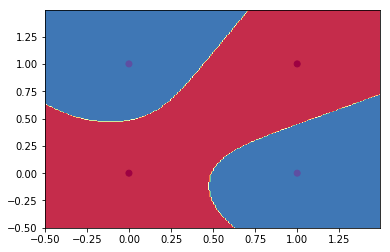

In [88]:
plot_decision_boundary(lambda x: prediction(x))

#### And gate 

In [89]:
train_X = np.array([[1, 1], [1, 0], [0, 1], [0, 0]])
train_y = np.array([1, 1, 1, 0])

In [90]:
build_model(print_loss=True)

Loss after iteration 0: 0.769078
Loss after iteration 1000: 0.103026
Loss after iteration 2000: 0.057478
Loss after iteration 3000: 0.045957
Loss after iteration 4000: 0.041489
Loss after iteration 5000: 0.039324
Loss after iteration 6000: 0.038112
Loss after iteration 7000: 0.037359
Loss after iteration 8000: 0.036850
Loss after iteration 9000: 0.036480


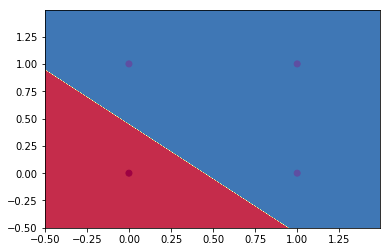

In [91]:
plot_decision_boundary(lambda x: prediction(x))